In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# First : exploring the data

We'll need to have a look at what the data is, how it is distributed for the different features, and start to get an intuition about what methods might work better for analysis and prediction later.

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [3]:
# remove samples with error values
idx_c = np.all(tX!=-999, axis=1)
y_c = y[idx_c]
tX_c = tX[idx_c]
# regularize
mean = np.mean(tX_c, axis=0)
std = np.std(tX_c, axis=0)
tX_c = (tX_c-mean)/std

In [4]:
print("Overall: s: ",np.sum(y==1),", b: ",np.sum(y==-1)," ,total:",len(y))
print("NoErrors: s: ",np.sum(y_c==1),", b: ",np.sum(y_c==-1)," ,total:",len(y_c))
# for n in range(tX_c.shape[1]):
#     plt.figure(figsize=(20,4))
#     plt.subplot(131)
#     plt.hist([tX_c[y_c==1,n],tX_c[y_c==-1,n]], 20, density=True, histtype='bar', stacked=True)
#     plt.legend(['s','b'])
#     plt.title('Feature '+str(n))
#     plt.subplot(132)
#     plt.title('s histogram feature '+str(n))
#     plt.hist(tX_c[y_c==1,n], 20, density=True, histtype='bar', stacked=True)
#     plt.subplot(133)
#     plt.title('b histogram feature '+str(n))
#     plt.hist(tX_c[y_c==-1,n], 20, density=True, histtype='bar', stacked=True)    
#     plt.show()

Overall: s:  85667 , b:  164333  ,total: 250000
NoErrors: s:  31894 , b:  36220  ,total: 68114


In [5]:
# remove features with error values
idx_gf = np.arange(tX.shape[1])[np.all(tX!=-999, axis=0)]
y_gf = y
tX_gf = tX[:,idx_gf]
# regularize
mean = np.mean(tX_gf, axis=0)
std = np.std(tX_gf, axis=0)
tX_gf = (tX_gf-mean)/std

In [6]:
print("Overall: s: ",np.sum(y==1),", b: ",np.sum(y==-1)," ,total:",len(y))
# for n in range(tX_gf.shape[1]):
#     plt.figure(figsize=(20,4))
#     plt.subplot(131)
#     plt.hist([tX_gf[y_gf==1,n],tX_gf[y_gf==-1,n]], 20, density=True, histtype='bar', stacked=True)
#     plt.legend(['s','b'])
#     plt.title('Feature '+str(idx_gf[n]))
#     plt.subplot(132)
#     plt.title('s histogram feature '+str(idx_gf[n]))
#     plt.hist(tX_gf[y_gf==1,n], 20, density=True, histtype='bar', stacked=True)
#     plt.subplot(133)
#     plt.title('b histogram feature '+str(idx_gf[n]))
#     plt.hist(tX_gf[y_gf==-1,n], 20, density=True, histtype='bar', stacked=True)    
#     plt.show()

Overall: s:  85667 , b:  164333  ,total: 250000


# Actual predictions start from here

After having looked at the data we will now do some actual predictions using different models andd parameters.

## Load the test data

In [7]:
from proj1_helpers import *
DATA_TEST_PATH = '../data/test.csv' 
_ , test_X, ids_test = load_csv_data(DATA_TEST_PATH) # test y is only ? marks, so we just discard it on import with _

## Generate predictions using only features with no errrors throughought

This enables us to use some of the methods from the course directly, without having to adjust some of the functionnality to account for the fact that a lot of errors are in the dataset. First let us see which features from the test dataset are error free.

In [8]:
# Import test data

import pandas as pd

test_x_df = pd.read_csv(DATA_TEST_PATH, index_col='Id').drop('Prediction', axis='columns')
# test_y_df Not useful because already have test_y which is all good values

train_x_df = pd.read_csv(DATA_TRAIN_PATH, index_col='Id').drop('Prediction', axis='columns')
# train_y_df Not useful because we already have y which is all good values for train data

In [9]:
# test_x_df

In [10]:
# train_x_df

In [11]:
# Remove columns with -999 errors
error_cols_te = np.full(test_x_df.shape[1], False)
for i in range(test_x_df.shape[1]):
#     print(test_x_df.iloc[:,i].values)
#     print(-999.0 in test_x_df.iloc[:,i].values)
    if -999.0 in test_x_df.iloc[:,i].values:
        error_cols_te[i] = True
#print(f"There are {error_cols_te.tolist().count(True)} test error columns are which are : \n{error_cols_te}\n")

error_cols_tr = np.full(train_x_df.shape[1], False)
for i in range(train_x_df.shape[1]):
    if -999.0 in train_x_df.iloc[:,i].values:
        error_cols_tr[i] = True
#print(f"There are {error_cols_tr.tolist().count(True)} train error columns are which are : \n{error_cols_tr}")

no_error_cols_tr_te = (~(error_cols_tr | error_cols_te)).tolist()
#print(f"They have {no_error_cols_tr_te.count(True)} following shared non error columns :\n{no_error_cols_tr_te}")

With this figured out we can now extract the valid columns from test and train data, do some training and testing on data, then generate answers for the test data and submit to aicrowd !

In [12]:
no_err_train_x_df = train_x_df.T[no_error_cols_tr_te].T
no_err_test_x_df = test_x_df.T[no_error_cols_tr_te].T

In [13]:
#no_err_train_x_df

In [14]:
#no_err_test_x_df

Also, note that the train y values are labeled s or b, when we actually want 1 or -1. We'll use the y_c train data imported before.

### First using ridge regression

For this we will need to split our train data into train/train and train/test data, to see if we start overfitting.

In [81]:
from lab3_plots import plot_train_test
from th_helpers import build_poly, split_data, compute_rmse
from th_ridge_regression import ridge_regression

def ridge_regression_lambdas(x, y, degree, ratio, seed, lambdas=np.logspace(-5, 0, 15)):
    """Performs ridge regression with multiple lambdas."""
    # split the data, and return train and test data: TODO
    train_x, train_y, test_x, test_y = split_data(x, y, ratio, seed)

    # form train and test data with polynomial basis function: TODO
    train_x_aug = build_poly(train_x, degree)
    test_x_aug = build_poly(test_x, degree)

    rmse_tr = []
    rmse_te = []
    
    min_w_te = []
    min_rmse_te = -1
    best_lambda = False
    
    for ind, lambda_ in enumerate(lambdas):

        # ridge regression with a given lambda        
        w = ridge_regression(train_y, train_x_aug, lambda_)
        
        rmse_tr.append(compute_rmse(train_y, train_x_aug, w))
        rmse_te.append(compute_rmse(test_y, test_x_aug, w))
        
        if rmse_te[ind] < min_rmse_te or min_rmse_te == -1:
            min_rmse_te = rmse_te[ind]
            min_w_te = w
            best_lambda = lambda_
        
        # ***************************************************
#         print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
#                p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    #print(f"Degree={degree}, ratio={np.round(ratio, 3)}, seed={seed}, min test RMSE={np.round(min_rmse_te, 4)} for lambda={np.round(best_lambda, 7)}")
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)
    
    return min_rmse_te, min_w_te, best_lambda

# THEOTEST code
# ridge_regression_demo(x=np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).T, 
#                       y=np.array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]).T,
#                       degree = 3,
#                       ratio = 0.7,
#                       seed = 56)

Starting degree 11


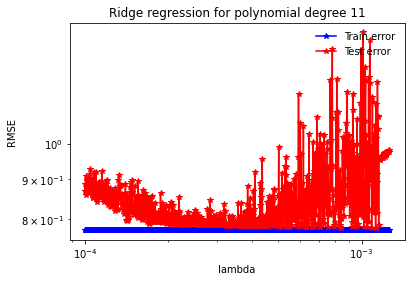

Correctness improved at RMSE=0.61355, degree=11, splitratio=0.9 : correctness=79.2084%


 Best best values are degree=11, ratio=0.9, RMSE=0.7799718386482447, lambda=0.0011232 correctness=79.2084%


In [92]:
seed = 137
start_degree = 11
max_degree = 11
start_split_ratio = 0.9
end_split_ratio = 0.95
split_step = 0.1
lambdas = np.logspace(-4, -2.9, 1000)

ratio_steps = 10

best_best_w = []
best_best_rmse = -1
best_degree = -1
best_best_lambda = False
best_ratio = -1
best_correctness = -1

for degree_i in np.arange(start=(start_degree-1), stop=max_degree):
    print(f"Starting degree {np.round(degree_i+1,2)}")
    for split_ratio in np.arange(start=start_split_ratio, stop=end_split_ratio, step=split_step):
        min_rmse_te, min_w_te, best_lambda = ridge_regression_lambdas(no_err_train_x_df.to_numpy(), y, degree_i+1, split_ratio, seed, lambdas)

        # Compute values for train data adjusted for -1 and 1 values predicted
        train_x_aug_theo = build_poly(no_err_train_x_df.to_numpy(), degree_i+1)
        y_out_train = np.dot(train_x_aug_theo, min_w_te)

        # Count how many outputs are correctly predicted vs not correctly
        y_out_train[y_out_train>=0] = 1
        y_out_train[y_out_train<0] = -1
        #print(f"When -1 or 1 RMSE={ np.round(compute_rmse(y_out_train, train_x_aug_theo, min_w_te), 5)}, correctness={100*(y_out_train == y).tolist().count(True)/y_out_train.shape[0]}%\n")
        correctness = 100*(y_out_train == y).tolist().count(True)/y_out_train.shape[0]

        if correctness > best_correctness:
            best_best_rmse = min_rmse_te
            best_best_w = min_w_te
            best_degree = degree_i+1
            best_best_lambda = best_lambda
            best_correctness = correctness
            best_ratio = split_ratio
            complete_train_data_rmse = np.round(compute_rmse(y_out_train, train_x_aug_theo, best_best_w), 5)
            print(f"Correctness improved at RMSE={complete_train_data_rmse}, degree={best_degree}, splitratio={np.round(best_ratio, 2)} : correctness={best_correctness}%\n")

# Compute values for train data adjusted for -1 and 1 values predicted
best_best_train_x_aug_theo = build_poly(no_err_train_x_df.to_numpy(), best_degree)
best_best_y_out_train = np.dot(best_best_train_x_aug_theo, best_best_w)

# Count how many outputs are correctly predicted vs not correctly
best_best_y_out_train[best_best_y_out_train>=0] = 1
best_best_y_out_train[best_best_y_out_train<0] = -1
best_correctness_ratio_prct = 100*(best_best_y_out_train == y).tolist().count(True)/best_best_y_out_train.shape[0]
print(f"\n Best best values are degree={best_degree}, ratio={best_ratio}, RMSE={best_best_rmse}, lambda={np.round(best_best_lambda, 7)} correctness={best_correctness_ratio_prct}%")

Once some good parameters are found, we will train one last time on the whole dataset (Att : keep same parameters otherwise it doesn't make sense !).
Because we are keeping the same lambda an degree, and other parameters, the over/under fitting state of the model should'nt change,
but by adding more datapoints it should be more accurate.

In [68]:
# Train one last time but on complete dataset
last_train_x_aug = build_poly(no_err_train_x_df.to_numpy(), best_degree)
best_last_w = ridge_regression(y, last_train_x_aug, best_best_lambda)

#Last check of correctness ratio
last_y_train_pred = np.dot(last_train_x_aug, best_last_w)

last_y_train_pred[last_y_train_pred>=0] = 1
last_y_train_pred[last_y_train_pred<0] = -1
print(f"Correctness ratio for all train data={100*(last_y_train_pred == y).tolist().count(True)/last_y_train_pred.shape[0]}%")

# Compute values for the test set, in order to submit them
last_test_x_aug = build_poly(no_err_test_x_df.to_numpy(), best_degree)
last_y_test_out = np.dot(last_test_x_aug, best_last_w)

last_y_test_out[last_y_test_out>=0] = 1
last_y_test_out[last_y_test_out<0] = -1

LAST_OUT_NAME = f"submit_ridge_seed{seed}_deg{degree}.csv"
create_csv_submission(ids_test, last_y_test_out, LAST_OUT_NAME)
print("Correctly created file with name=", LAST_OUT_NAME)

Correctness ratio for all train data=79.3596%
Correctly created file with name= submit_ridge_seed137_deg13.csv


### We can also see what happens when we cross multiply parameters



## Generate predictions after setting error values to mean of the other column values



# Save prediction ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)